## Main goal -> test methods in book on real data

In [232]:
import yfinance as yf
import pandas as pd
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import numpy as np
from scipy.linalg import block_diag
from sklearn.covariance import LedoitWolf
from tqdm.notebook import tqdm
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.linalg import block_diag
from sklearn.utils import check_random_state
np.random.seed(0)

In [503]:
class SP500_Dataset():
    '''
    Class to parse S&P500 data from yahoo finance
    '''
    def __init__(self,start_date:str, end_date:str,filter_ = 'Adj Close'):
        self.start_date=start_date
        self.end_date=end_date

        self.sp500_names_of_corp = self.get_wiki_tickers()
        self.data = self.parse_sp500(self.sp500_names_of_corp)
        self.data = self.preprocess_sp(data = self.data,filter_ = filter_)

    def get_wiki_tickers(self):
        '''
        Parse companies' names from wiki into pandas Series
        :return: pd.Series
        '''
        sp500_wiki = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies') #Wiki page about S&P500
        sp500_names_of_corp = list(sp500_wiki[0].Symbol) #Extract only names of corporations
        #yf can't download these companies:
        sp500_names_of_corp.remove('BF.B')
        sp500_names_of_corp.remove('BRK.B')
        sp500_names_of_corp.remove('CEG')
        return sp500_names_of_corp

    def parse_sp500(self,data):
        '''
        Download data from yfinance
        :param data: List of companies' names (tickers)
        :return: pd.Series
        '''
        sp500_data_raw = yf.download(tickers = data, start = self.start_date,
                                     end = self.end_date, interval = "1d")
        return sp500_data_raw
    def preprocess_sp(self,data, filter_ = 'Adj Close'):
        '''
        Remove stocks that have null values, and convert prices to yield
        :param data: pd.Series with data
        :param filter: type of price you want to focus on
        :return: pd.Series
        '''
        data = data[filter_]
        data = data.dropna(axis=1)
        data = data.apply(np.log).diff(1)
        data = data.dropna(axis=0)
        return data
    def visualize(self):
        plt.figure(figsize=(16,8))
        plt.title('Correlation matrix for noisy data')
        corr_sp500 = self.data.corr()
        sns.heatmap(data = corr_sp500, annot = False)
    


In [504]:
dataset = SP500_Dataset(start_date='2016-01-01',end_date='2021-01-01')

[*********************100%***********************]  500 of 500 completed

1 Failed download:
- OGN: Data doesn't exist for startDate = 1451624400, endDate = 1609477200


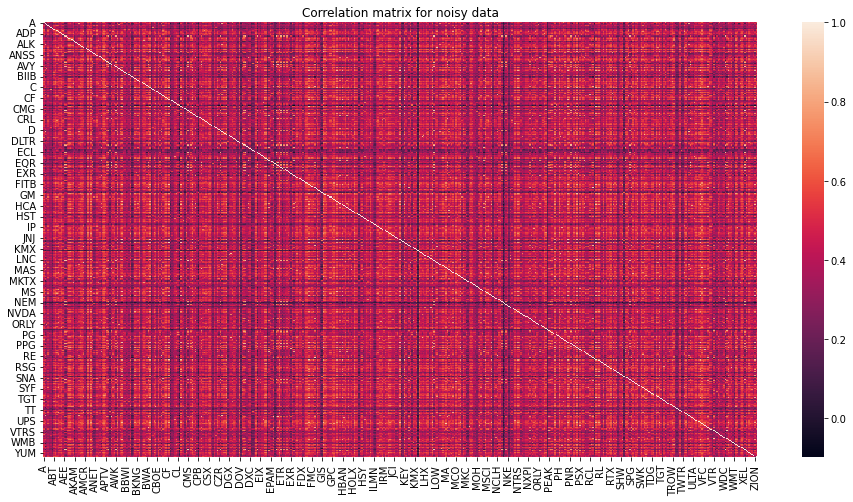

In [505]:
dataset.visualize()

In [543]:
class Chapter2:
    def __init__(self,dataset:pd.Series):
        self.dataset = dataset
        self.t = self.dataset.shape[0]
        self.n = self.dataset.shape[1]
        self.q = self.t // self.n
        self.cor = dataset.corr()
    #- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -
    def getPCA(self, cor):
        # Get eVal,eVec from a Hermitian matrix
        eVal,eVec=np.linalg.eigh(cor)
        indices=eVal.argsort()[::-1] # arguments for sorting eVal desc
        eVal,eVec=eVal[indices],eVec[:,indices]
        eVal=np.diagflat(eVal)
        return eVal,eVec
    #- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -
    def fitKDE(self,obs,bWidth=.25,kernel='gaussian',x=None):
        # Fit kernel to a series of obs, and derive the prob of obs
        # x is the array of values on which the fit KDE will be evaluated
        if len(obs.shape)==1:obs=obs.reshape(-1,1)
        kde=KernelDensity(kernel=kernel,bandwidth=bWidth).fit(obs)
        if x is None:x=np.unique(obs).reshape(-1,1)
        if len(x.shape)==1:x=x.reshape(-1,1)
        logProb=kde.score_samples(x) # log(density)
        pdf=pd.Series(np.exp(logProb),index=x.flatten())
        return pdf
    #- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
    def mpPDF(self, var, pts):
        eMin, eMax = var*(1-(1./self.q)**.5)**2, var*(1+(1./self.q)**.5)**2 # calc lambda_minus, lambda_plus
        eVal = np.linspace(eMin, eMax, pts) #Return evenly spaced numbers over a specified interval. eVal='lambda'
        #Note: 1.0/2*2 = 1.0 not 0.25=1.0/(2*2)
        pdf = self.q/(2*np.pi*var*eVal)*((eMax-eVal)*(eVal-eMin))**.5 #np.allclose(np.flip((eMax-eVal)), (eVal-eMin))==True
        pdf = pd.Series(pdf, index=eVal)
        return pdf

    #- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
    def cov2corr(self,cov):
        # Derive the correlation matrix from a covariance matrix
        std=np.sqrt(np.diag(cov))
        corr=cov/np.outer(std,std)
        corr[corr<-1],corr[corr>1]=-1,1 # numerical error
        return corr
    #- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
    def errPDFs(self,var,eVal,bWidth):
        var = var[0]
        pdf0=self.mpPDF(var,self.n) # theoretical pdf
        pdf1=self.fitKDE(eVal,bWidth,x=pdf0.index.values) # empirical pdf
        sse=np.sum((pdf1-pdf0)**2)
        return sse
    #- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
    def findMaxEval(self,eVal,bWidth):
        # Find max random eVal by fitting Marcenko’s dist
        out=minimize(lambda *x:self.errPDFs(*x),.5,args=(eVal,bWidth),
        bounds=((1E-5,1-1E-5),))
        print("found err PDFs "+str(out['x'][0]))
        if out['success']:var=out['x'][0]
        else:var=1
        eMax=var*(1+(1./self.q)**.5)**2
        return eMax,var
    def visualize(self):
        alpha=.995
        pdf0 = self.mpPDF(var0, pts=self.n)
        fig = plt.figure()
        ax  = fig.add_subplot(111)
        ax.hist(np.diag(eVal0), density = True, bins=50) # Histogram the eigenvalues

        plt.plot(pdf0.keys(), pdf0, color='r', label="Marcenko-Pastur pdf")
        plt.legend(loc="upper right")
        plt.show() 
        
    def denoise_res_eigen(self, eVal, eVec, nFacts):
        # Remove noise from corr by fixing random eigenvalues
        eVal_=np.diag(eVal).copy()
        eVal_[nFacts:]=eVal_[nFacts:].sum()/float(eVal_.shape[0]-nFacts)
        eVal_=np.diag(eVal_)
        corr1=np.dot(eVec,eVal_).dot(eVec.T)
        corr1=cov2corr(corr1)
        self.visualize_denoised(corr1,eVal)
        return corr1

    def denoise_targeted_shrinkage(self, eVal, eVec, nFacts, alpha=0):
        # Remove noise from corr through targeted shrinkage
        eValL,eVecL=eVal[:nFacts,:nFacts],eVec[:,:nFacts]
        eValR,eVecR=eVal[nFacts:,nFacts:],eVec[:,nFacts:]
        corr0=np.dot(eVecL,eValL).dot(eVecL.T)
        corr1=np.dot(eVecR,eValR).dot(eVecR.T)
        corr2=corr0+alpha*corr1+(1-alpha)*np.diag(np.diag(corr1))
        self.visualize_denoised(corr2,eVal)
        return corr2
    
    def visualize_denoised(self, cor, val):
        val_denoised, vec_denoised = data.getPCA(cor)
        denoised_eigenvalue = np.diag(val_denoised)
        eigenvalue_prior = np.diag(val)
        plt.plot(range(0, len(denoised_eigenvalue)), np.log(denoised_eigenvalue), color='r', label="Denoised eigen-function")
        plt.plot(range(0, len(eigenvalue_prior)), np.log(eigenvalue_prior), color='g', label="Original eigen-function")
        plt.xlabel("Eigenvalue number")
        plt.ylabel("Eigenvalue (log-scale)")
        plt.legend(loc="upper right")
        plt.show()
    
    def detoned_corr(self, corr, eigenvalues, eigenvectors, market_component=1):
        """
        De-tones the de-noised correlation matrix by removing the market component.
        :param corr: Correlation matrix to detone
        :param eigenvalues: Matrix with eigenvalues on the main diagonal
        :param eigenvectors: Eigenvectors array
        :param market_component: Number of fist eigevectors related to a market component
        :return: np.array
        """

        # Getting the eigenvalues and eigenvectors related to market component
        eigenvalues_mark = eigenvalues[:market_component, :market_component]
        eigenvectors_mark = eigenvectors[:, :market_component]

        # Calculating the market component correlation
        corr_mark = np.dot(eigenvectors_mark, eigenvalues_mark).dot(eigenvectors_mark.T)

        # Removing the market component from the de-noised correlation matrix
        corr = corr - corr_mark

        # Rescaling the correlation matrix to have 1s on the main diagonal
        corr = cov2corr(corr)

        return corr

In [544]:
ch2 = Chapter2(dataset.data)

In [545]:
eVal0,eVec0=data.getPCA(ch2.cor)

In [546]:
eMax0,var0=ch2.findMaxEval(np.diag(eVal0),bWidth=.01)
nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)

found err PDFs 0.2970551935769979


### 70% of variance can be attributed to signal

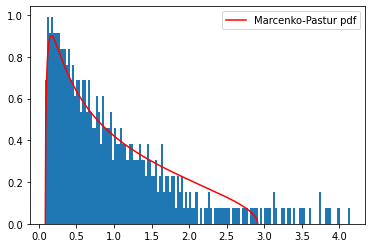

In [102]:
ch2.visualize()

In [548]:
eMax0

0.8656822738954523

In [549]:
nFacts0

68

## Denoising

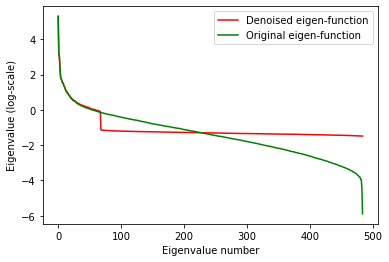

In [550]:
cor_denoised_re = ch2.denoise_res_eigen(eVal0, eVec0, nFacts0)   

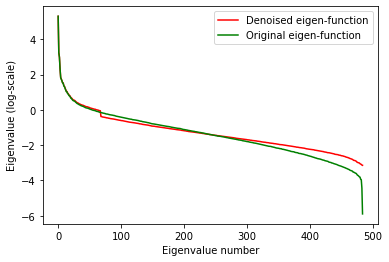

In [501]:
cor_denoised_ts = ch2.denoise_targeted_shrinkage(eVal0, eVec0, nFacts0, alpha =0.7)   

In [552]:
cor_detoned = ch2.detoned_corr(ch2.cor, eVal0,eVec0)
eVal_detoned, eVec_detoned = ch2.getPCA(cor_detoned)

In [553]:
class Chapter4:
    def __init__(self,dataset:pd.Series, cor = None):
        self.dataset = dataset
        if cor is None:
            self.cor = dataset.corr()
        else:
            self.cor = pd.DataFrame(cor)
            
    def clusterKMeansBase(self,corr, maxNumClusters=10, n_init=10):
        '''
        Evaluate the correlation matrix as distance matrix,
        we try different k=2..N on which to cluster with kmeans
        and evaluate q = E(silhouette)/std(silhouette) for all clusters.
        The outer loop repeats inner loop with initializations of different centroid seeds
        :param corr: Correlation matrix
        :param maxNumClusters: maximum number of clusters that can be found
        :param n_init: how many tries of different centroid seeds to make
        :return: pd.Series, dict, pd.Series
        '''
        corr[corr > 1] = 1 # Correlation is maximum 1
        dist_matrix = ((1-corr.fillna(0))/2.)**.5
        silh_coef_optimal = pd.Series(dtype='float64') # Observations matrixes
        kmeans, stat = None, None
        
        maxNumClusters = min(maxNumClusters, int(np.floor(dist_matrix.shape[0]/2)))
        # Max amount of clusters (e.g not possible to make 5 clusters on 2 points)
        print("maxNumClusters"+str(maxNumClusters))
        
        for num_clusters in tqdm(range(2, maxNumClusters+1)):
            #New iteration = new centroid seed
            kmeans_ = KMeans(n_clusters=num_clusters, n_init=n_init)
            kmeans_ = kmeans_.fit(dist_matrix)
            
            silh_coef = silhouette_samples(dist_matrix, kmeans_.labels_) # Calculate silhouette scores
            stat = (silh_coef.mean()/silh_coef.std(), silh_coef_optimal.mean()/silh_coef_optimal.std())
            # Comparing clustering quality
            # If this metric better than the previous set as the optimal number of clusters
            if np.isnan(stat[1]) or stat[0] > stat[1]:
                silh_coef_optimal = silh_coef
                kmeans = kmeans_
                print(kmeans)
                print(stat)
                silhouette_avg = silhouette_score(dist_matrix, kmeans_.labels_)
                print("For n_clusters ="+ str(num_clusters)+ "The average silhouette_score is :"+ str(silhouette_avg))
                print("********")

        newIdx = np.argsort(kmeans.labels_)

        corr1 = corr.iloc[newIdx] # Reorder rows
        corr1 = corr1.iloc[:, newIdx] # Reorder columns

        clstrs = {i:corr.columns[np.where(kmeans.labels_==i)[0]].tolist() for i in np.unique(kmeans.labels_)} # Cluster members
        silh_coef_optimal = pd.Series(silh_coef_optimal, index=dist_matrix.index) # Optimal coefficients

        return corr1, clstrs, silh_coef_optimal
    
    def makeNewOutputs(self,corr, clstrs, clstrs2):
        '''
        Improve number clusters using silh scores
        :param corr: Correlation matrix
        :param clstrs: First cluster to merge
        :param clstrs2: Second cluster to merge
        :return: pd.Series, dict, pd.Series
        '''
        clstrsNew, newIdx = {}, []
        for i in clstrs.keys():
            clstrsNew[len(clstrsNew.keys())] = list(clstrs[i])

        for i in clstrs2.keys():
            clstrsNew[len(clstrsNew.keys())] = list(clstrs2[i])

        newIdx = [j for i in clstrsNew for j in clstrsNew[i]]
        corrNew = corr.loc[newIdx, newIdx]

        dist = ((1 - corr.fillna(0)) / 2.)**.5
        kmeans_labels = np.zeros(len(dist.columns))
        for i in clstrsNew.keys():
            idxs = [dist.index.get_loc(k) for k in clstrsNew[i]]
            kmeans_labels[idxs] = i

        silhNew = pd.Series(silhouette_samples(dist, kmeans_labels), index=dist.index)

        return corrNew, clstrsNew, silhNew
    
    def clusterKMeansTop(self, corr: pd.DataFrame, maxNumClusters=None, n_init=10):
        '''
        Make Base clustering, find clusters with quality below average,
        if amount of these clusters >=2: rerun clustering in those clusters 
        :param corr: Correlation matrix
        :param maxNumClusters: Maximum number of clusters
        :return: pd.Series, dict, pd.Series
        '''
        if maxNumClusters == None:
            maxNumClusters = corr.shape[1]-1

        corr1, clstrs, silh = self.clusterKMeansBase(corr, maxNumClusters=min(maxNumClusters, corr.shape[1]-1), n_init=10)#n_init)
        print("clstrs length:"+str(len(clstrs.keys())))
        print("best clustr:"+str(len(clstrs.keys())))

        clusterTstats = {i:np.mean(silh[clstrs[i]])/np.std(silh[clstrs[i]]) for i in clstrs.keys()} # Calculate clusters' quality
        tStatMean = sum(clusterTstats.values())/len(clusterTstats) # Average quality of clusters
        redoClusters = [i for i in clusterTstats.keys() if clusterTstats[i] < tStatMean] # If quality<average, we queue for redoing
        if len(redoClusters) <= 2:
            print("If 2 or less clusters have a quality rating less than the average then stop.")
            print("redoCluster <=1:"+str(redoClusters)+" clstrs len:"+str(len(clstrs.keys())))
            return corr1, clstrs, silh
        else:
            keysRedo = [j for i in redoClusters for j in clstrs[i]]
            corrTmp = corr.loc[keysRedo, keysRedo]
            _, clstrs2, _ = self.clusterKMeansTop(corrTmp, maxNumClusters=min(maxNumClusters, corrTmp.shape[1]-1), n_init=n_init)
            print("clstrs2.len, stat:"+str(len(clstrs2.keys())))
            
            dict_redo_clstrs = {i:clstrs[i] for i in clstrs.keys() if i not in redoClusters} 
            corrNew, clstrsNew, silhNew = self.makeNewOutputs(corr, dict_redo_clstrs, clstrs2) # Make new outputs, if necessary
            newTstatMean = np.mean([np.mean(silhNew[clstrsNew[i]])/np.std(silhNew[clstrsNew[i]]) for i in clstrsNew.keys()]) 
            # If new quality > prev quality return new clusters, otherwise skip
            if newTstatMean <= tStatMean:
                print("newTstatMean <= tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))+" <= "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
                return corr1, clstrs, silh
            else: 
                print("newTstatMean > tStatMean"+str(newTstatMean)+ " (len:newClst)"+str(len(clstrsNew.keys()))
                      +" > "+str(tStatMean)+ " (len:Clst)"+str(len(clstrs.keys())))
                return corrNew, clstrsNew, silhNew
    
    # For generating random correlation matrix
    def getCovSub(self, nObs, nCols, sigma, random_state=None):
        '''
        Sub-correlation matrix
        Each column is highly correlated for small sigma and less correlated for large sigma
        :param nObs: Number of Rows
        :param nCols: Number of columns
        :param sigma: std
        :return: np.array
        '''
        rng = check_random_state(random_state) # Set random state (if neccessary)
        if nCols == 1:
            return np.ones((1,1))
        ar0 = rng.normal(size=(nObs, 1)) # Array of normal rv
        ar0 = np.repeat(ar0, nCols, axis=1) # Matrix of columns repeating rv. 
        ar0 += rng.normal(loc=0, scale=sigma, size=ar0.shape) #add two rv X~Y~N(0,1), Z=X+Y~N(0+0, 1+1)=N(0,2)
        ar0 = np.cov(ar0, rowvar=False) #ar0.shape = nCols x nCols
        return ar0

    def getRndBlockCov(self, nCols, nBlocks, minBlockSize=1, sigma=1., random_state=None):
        '''
        Generate a block random covariance matrix
        :param nCols: Number of columns
        :param nBlocks: Number of blocks
        :param minBlockSize: min nxn covariance block size
        :param sigma: std
        :return: np.array
        '''
        print("getRndBlockCov:"+str(minBlockSize))
        rng = check_random_state(random_state)
        parts = rng.choice(range(1, nCols-(minBlockSize-1)*nBlocks), nBlocks-1, replace=False)
        parts.sort()
        parts = np.append(parts, nCols-(minBlockSize-1)*nBlocks) # Add nCols to list of parts, unless minBlockSize>1
        parts = np.append(parts[0], np.diff(parts))-1+minBlockSize
        print("block sizes:"+str(parts))
        cov=None
        for nCols_ in parts:
            cov_ = self.getCovSub(int(max(nCols_*(nCols_+1)/2., 100)), nCols_, sigma, random_state=rng)
            if cov is None:
                cov = cov_.copy()
            else: 
                cov = block_diag(cov, cov_) # List of square matrix on larger matrix on the diagonal

        return cov

    def randomBlockCorr(self, nCols, nBlocks, random_state=None, minBlockSize=1):
        '''
        Add two random covariance matrixes, the first consists of nBlocks
        The second matrix consists of 1 block - which adds noice
        :param nCols: Number of columns
        :param nBlocks: Number of blocks
        :param random_state: Control randomness
        :param minBlockSize: min nxn covariance block size
        :return: pd.Series
        '''
        rng = check_random_state(random_state)

        print("randomBlockCorr:"+str(minBlockSize))
        cov0 = self.getRndBlockCov(nCols, nBlocks, minBlockSize=minBlockSize, sigma=.5, random_state=rng)
        cov1 = self.getRndBlockCov(nCols, 1, minBlockSize=minBlockSize, sigma=1., random_state=rng) #add noise
        cov0 += cov1
        corr0 = cov2corr(cov0)
        corr0 = pd.DataFrame(corr0)
        return corr0
    
    def visualize(self,cor):
        #Draw ground truth
        plt.matshow(cor) #invert y-axis to get origo at lower left corner
        plt.gca().xaxis.tick_bottom()
        plt.gca().invert_yaxis()
        plt.colorbar()
        plt.show()
    
    def test_synthetic_data(self, nCols, nBlocks, maxNumClusters, random_state=42):
        corr_synth = self.randomBlockCorr(nCols,nBlocks,random_state=42)
        corr1 = self.clusterKMeansTop(corr_synth, maxNumClusters = maxNumClusters) 
        self.visualize(corr_synth)

In [554]:
ch4 = Chapter4(dataset.data,cor_detoned)

randomBlockCorr:1
getRndBlockCov:1
block sizes:[182 237  28  28  10]
getRndBlockCov:1
block sizes:[485]
maxNumClusters20


  0%|          | 0/19 [00:00<?, ?it/s]

KMeans(n_clusters=2)
(3.63330168325025, nan)
For n_clusters =2The average silhouette_score is :0.6683677489145934
********
KMeans(n_clusters=3)
(9.99531994866212, 3.63330168325025)
For n_clusters =3The average silhouette_score is :0.7177917967353298
********
clstrs length:3
best clustr:3
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[2] clstrs len:3


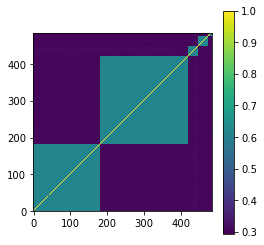

In [540]:
# Let's test methods on synthetic data
nCols, nBlocks = 485, 5

ch4.test_synthetic_data(nCols, nBlocks, maxNumClusters=20, random_state=42)

## works more or less good, only 3 clusters but on graph we see that it works

maxNumClusters20


  0%|          | 0/19 [00:00<?, ?it/s]

KMeans(n_clusters=2)
(2.142843190999307, nan)
For n_clusters =2The average silhouette_score is :0.21117374851490892
********
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[0] clstrs len:2


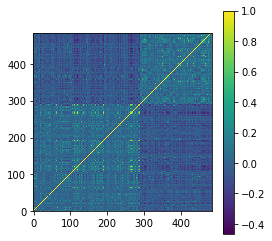

In [606]:
# Now let's test on real data (after detoning)

cor_clustered, clusters, silh = ch4.clusterKMeansTop(ch4.cor, maxNumClusters = 20) 
ch4.visualize(cor_clustered)

### After a couple of simulations, the only result we get is 2 clusters, so lets try to see if we can find clusters inside these clusters

In [607]:
for i in range(len(clusters)):
    print(len(clusters[i]))
    
# I will focus on small cluster

290
195


In [614]:
class Recluster:
    def __init__(self,cluster,maxNumClusters):
        self.cluster = cluster
        self.maxNumClusters = clusterKMeansTop
        self.cor, self.clusters, self.silh = None, None, None
        
        self.new_data = self.extract_frame(self.cluster)
        self.cor, self.clusters, self.silh = self.recluster_new_data(self.new_data,maxNumClusters)
        
    def extract_frame(self,cluster):
        '''
        Extract data from indexes
        '''
        sorted_companies = sorted(cluster)
        for i in range(len(sorted_companies)):
            sorted_companies[i] = ch2.dataset.columns[i]
        new_data = dataset.data[sorted_companies]
        return new_data
    
    def recluster_new_data(self,new_data,maxNumClusters):
        '''
        Make a correlation of clustered data, detone, and build new clusters
        '''
        new_corr = new_data.corr()
        
        eVal0, eVec0 = ch2.getPCA(new_corr)
        new_corr_detoned = ch2.detoned_corr(new_corr, eVal0, eVec0) #Detone new data
        
        cor_clustered, clusters_new, silh_new = ch4.clusterKMeansTop(new_corr_detoned, maxNumClusters = maxNumClusters) 
        ch4.visualize(cor_clustered)
        return cor_clustered, clusters_new, silh_new

maxNumClusters50


  0%|          | 0/49 [00:00<?, ?it/s]

KMeans(n_clusters=2)
(1.95009865677614, nan)
For n_clusters =2The average silhouette_score is :0.18543137886754413
********
KMeans(n_clusters=3)
(2.000418161650605, 1.95009865677614)
For n_clusters =3The average silhouette_score is :0.20132806088292135
********
clstrs length:3
best clustr:3
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[1, 2] clstrs len:3


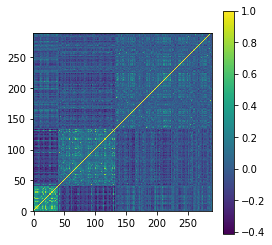

maxNumClusters50


  0%|          | 0/49 [00:00<?, ?it/s]

KMeans(n_clusters=2)
(2.644999324103138, nan)
For n_clusters =2The average silhouette_score is :0.2546819232300369
********
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[1] clstrs len:2


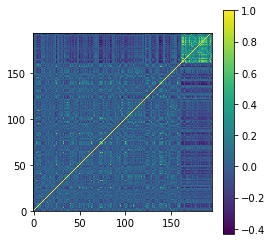

In [615]:
new_cluster = Recluster(clusters[0], 50)
new_cluster_1 = Recluster(clusters[1], 50)

In [616]:
def split_clusters_and_recluster(clusters_dict):
    new_clusters = {}
    for i in range(len(clusters_dict)):
        new_clusters[f'Cluster{i:2d}'] = Recluster(clusters_dict[i], 50)
    return new_clusters

maxNumClusters50


  0%|          | 0/49 [00:00<?, ?it/s]

KMeans(n_clusters=2)
(1.95009865677614, nan)
For n_clusters =2The average silhouette_score is :0.18543137886754413
********
KMeans(n_clusters=3)
(2.000418161650605, 1.95009865677614)
For n_clusters =3The average silhouette_score is :0.20132806088292135
********
clstrs length:3
best clustr:3
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[0, 2] clstrs len:3


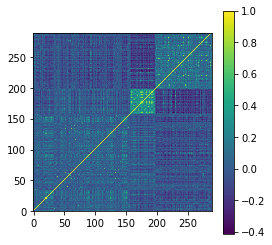

maxNumClusters50


  0%|          | 0/49 [00:00<?, ?it/s]

KMeans(n_clusters=2)
(2.644999324103138, nan)
For n_clusters =2The average silhouette_score is :0.2546819232300369
********
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[0] clstrs len:2


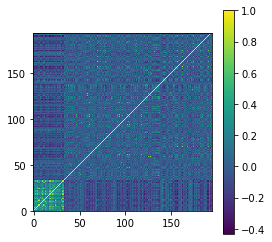

{'Cluster 0': <__main__.Recluster at 0x12ce1fd2f10>,
 'Cluster 1': <__main__.Recluster at 0x12ce1ecfdc0>}

In [617]:
cls = split_clusters_and_recluster(clusters)
cls

maxNumClusters50


  0%|          | 0/49 [00:00<?, ?it/s]

KMeans(n_clusters=2)
(1.7597819102799928, nan)
For n_clusters =2The average silhouette_score is :0.1651255897445813
********
KMeans(n_clusters=3)
(1.8272075623277524, 1.7597819102799928)
For n_clusters =3The average silhouette_score is :0.1839541552393271
********
clstrs length:3
best clustr:3
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[0] clstrs len:3


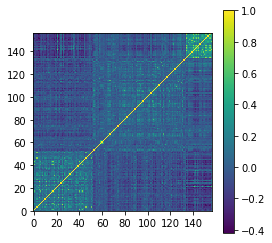

maxNumClusters20


  0%|          | 0/19 [00:00<?, ?it/s]

KMeans(n_clusters=2)
(1.741812197567988, nan)
For n_clusters =2The average silhouette_score is :0.10966873579780088
********
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[1] clstrs len:2


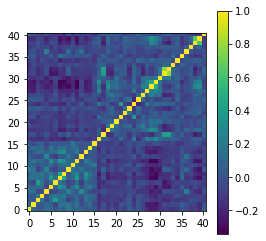

maxNumClusters46


  0%|          | 0/45 [00:00<?, ?it/s]

KMeans(n_clusters=2)
(1.698729311610008, nan)
For n_clusters =2The average silhouette_score is :0.13661509445152467
********
clstrs length:2
best clustr:2
If 2 or less clusters have a quality rating less than the average then stop.
redoCluster <=1:[1] clstrs len:2


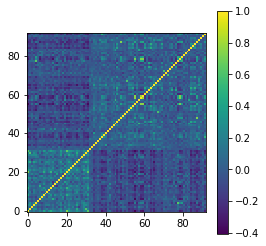

{'Cluster 0': <__main__.Recluster at 0x12ce1fcd730>,
 'Cluster 1': <__main__.Recluster at 0x12ce1f3fd30>,
 'Cluster 2': <__main__.Recluster at 0x12ce2a51400>}

In [619]:
cls_more = split_clusters_and_recluster(cls['Cluster 0'].clusters)
cls_more

### If we use kmeans top clustering method and continue splitting iteratively we can make hierarchical clustering.
Question: How we can check if we need to stop splitting and cluster more on real data?
Assumption: check clustering quality, comparing with upper level qualities.

# below in progress, because i didn't fully get it 

## Minimum Variance Portfolio

In [277]:
def formBlockMatrix(nBlocks,bSize,bCorr):
    block=np.ones((bSize,bSize))*bCorr
    block[range(bSize),range(bSize)]=1
    corr=block_diag(*([block]*nBlocks))
    return corr
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def formTrueMatrix(corr0=cor):
#     corr0=formBlockMatrix(nBlocks,bSize,bCorr)
#     corr0=pd.DataFrame(corr0)
    cols=corr0.columns.tolist()
    np.random.shuffle(cols)
    corr0=corr0[cols].loc[cols].copy(deep=True)
    std0=np.random.uniform(.05,.2,corr0.shape[0])
    cov0=corr2cov(corr0,std0)
    mu0=np.random.normal(std0,std0,cov0.shape[0]).reshape(-1,1)
    return mu0,cov0
#- - - - - - - -- - - - - - - -
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
# nBlocks,bSize,bCorr=10,50,.5
cov = data.cov()
std = cov.std()
cor = data.corr()
cor.fillna(0, inplace=True)
mu0,cov0=formTrueMatrix(cor)

In [279]:
def simCovMu(mu0,cov0,nObs,shrink=False):
    x=np.random.multivariate_normal(mu0.flatten(),cov0,size=nObs)
    mu1=x.mean(axis=0).reshape(-1,1)
    if shrink:cov1=LedoitWolf().fit(x).covariance_
    else:cov1=np.cov(x,rowvar=0)
    return mu1,cov1
# and the vector of means is drawn from a Normal
# distribution with mean and standard deviation equal to the standard deviation
# from the covariance matrix.

In [280]:
def corr2cov(corr,std):
    cov=corr*np.outer(std,std)
    return cov
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
def deNoiseCov(cov0,q,bWidth):
    corr0=cov2corr(cov0)
    eVal0,eVec0=getPCA(corr0)
    eMax0,var0=findMaxEval(np.diag(eVal0),q,bWidth)
    nFacts0=eVal0.shape[0]-np.diag(eVal0)[::-1].searchsorted(eMax0)
    corr1=denoisedCorr(eVal0,eVec0,nFacts0)
    cov1=corr2cov(corr1,np.diag(cov0)**.5)
    return cov1


In [281]:
def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
nObs,nTrials,bWidth,shrink,minVarPortf=data.shape[0],1000,.01,True,True
w1=pd.DataFrame(columns=range(cov0.shape[0]),
                index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in tqdm(range(2)):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    cov1_d=deNoiseCov(cov1,nObs*1.//cov1.shape[1],bWidth)
#     w1.loc[i]=optPort(cov1,mu1).flatten()
#     w1_d.loc[i]=optPort(cov1_d,mu1).flatten()


#err 0.99 why??

  0%|          | 0/2 [00:00<?, ?it/s]

found err PDFs 0.99999
found err PDFs 0.99999


In [149]:
w0=optPort(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE
print(rmsd,rmsd_d)

nan 0.0039353579803708474


In [150]:
def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
nObs,nTrials,bWidth,shrink,minVarPortf=1000,1000,.01,True,True
w1=pd.DataFrame(columns=range(cov0.shape[0]),
                index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in tqdm(range(nTrials)):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth)
#     w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()

  0%|          | 0/1000 [00:00<?, ?it/s]

In [151]:
w0=optPort(cov0,None if minVarPortf else mu0)
w0=np.repeat(w0.T,w1.shape[0],axis=0)
rmsd=np.mean((w1-w0).values.flatten()**2)**.5 # RMSE
rmsd_d=np.mean((w1_d-w0).values.flatten()**2)**.5 # RMSE
print(rmsd,rmsd_d)

nan 0.004085733602193406


## Random simulations

            Not denoised    Denoised    Denoised(ts,alpha=0.7)   Denoised(ts,alpha=0.2)
Not shrunk  4.95E–03        1.1E–03     2.6E-03                  1.3E-03
Shrunk      3.45E–03        1.3E–03     2.3E-03                  1.5E-03

## S&P 500 data

            Not denoised    Denoised    Denoised(ts,alpha=0.7)   Denoised(ts,alpha=0.2)
Not shrunk  5.21E-03        5.785E–03     3.95E-03                  4.66E-03
Shrunk      4.36E–03        5.792E–03     2.3E-03                  4.73E-03


In [191]:
import numpy as np

def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [192]:
is_pos_def(cor)

True

In [140]:
print(4.95E-03)
alpha 0.2
# 0.005214090319241825 0.004656278725493655
# 0.004365923056939735 0.00472773452328317


0.00495

In [ ]:
def optPort(cov,mu=None):
    inv=np.linalg.inv(cov)
    ones=np.ones(shape=(inv.shape[0],1))
    if mu is None:mu=ones
    w=np.dot(inv,mu)
    w/=np.dot(ones.T,w)
    return w
#- - - - - - - -- - - - - - - - - - - - -- - - - - - - - - - - - - -- - - - - - - - - - - - -- - -
nObs,nTrials,bWidth,shrink,minVarPortf=1000,1000,.01,True,True
w1=pd.DataFrame(columns=range(cov0.shape[0]),
                index=range(nTrials),dtype=float)
w1_d=w1.copy(deep=True)
np.random.seed(0)
for i in tqdm(range(nTrials)):
    mu1,cov1=simCovMu(mu0,cov0,nObs,shrink=shrink)
    if minVarPortf:mu1=None
    cov1_d=deNoiseCov(cov1,nObs*1./cov1.shape[1],bWidth)
#     w1.loc[i]=optPort(cov1,mu1).flatten()
    w1_d.loc[i]=optPort(cov1_d,mu1).flatten()